# Urban Greenspace and Asthma Prevalence

Get Started with Big Data Pipelines

Vegetation has the potential to provide many ecosystem services in Urban
areas, such as cleaner air and water and flood mitigation. However, the
results are mixed on relationships between a simple measurement of
vegetation cover (such as average NDVI, a measurement of vegetation
health) and human health. We do, however, find relationships between
landscape metrics that attempt to quantify the connectivity and
structure of greenspace and human health. These types of metrics include
mean patch size, edge density, and fragmentation.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out this study by <span class="citation"
data-cites="tsai_relationships_2019">@tsai_relationships_2019</span> on
the relationship between edge density and life expectancy in Baltimore,
MD. The authors also discuss the influence of scale (e.g. the resolution
of the imagery) on these relationships, which is important for this case
study.</p></div></div>

In this notebook, you will write code to calculate patch, edge, and
fragmentation statistics about urban greenspace in Chicago. These
statistics should be reflective of the connectivity and spread of urban
greenspace, which are important for ecosystem function and access. You
will then use a linear model to identify statistically significant
correlations between the distribution of greenspace and health data
compiled by the US Center for Disease Control.

### Working with larger-than-memory (big) data

For this project, we are going to split up the green space (NDVI) data
by census tract, because this matches the human health data from the
CDC. If we were interested in the average NDVI at this spatial scale, we
could easily use a source of multispectral data like Landsat (30m) or
even MODIS (250m) without a noticeable impact on our results. However,
because we need to know more about the structure of green space within
each tract, we need higher resolution data. For that, we will access the
National Agricultural Imagery Program (NAIP) data, which is taken for
the continental US every few years at 1m resolution. That’s enough to
see individual trees and cars! The main purpose of the NAIP data is, as
the name suggests, agriculture. However, it’s also a great source for
urban areas where lots is happening on a very small scale.

The NAIP data for the City of Chicago takes up about 20GB of space. This
amount of data is likely to crash your kernel if you try to load it all
in at once. It also would be inconvenient to store on your harddrive so
that you can load it in a bit at a time for analysis. Even if your are
using a computer that would be able to handle this amount of data,
imagine if you were analysing the entire United States over multiple
years!

To help with this problem, you will use cloud-based tools to calculate
your statistics instead of downloading rasters to your computer or
container. You can crop the data entirely in the cloud, thereby saving
on your memory and internet connection, using `rioxarray`.

### Check your work with testing!

This notebook does not have pre-built tests. You will need to write your
own test code to make sure everything is working the way that you want.
For many operations, this will be as simple as creating a plot to check
that all your data lines up spatially the way you were expecting, or
printing values as you go. However, if you don’t test as you go, you are
likely to end up with intractable problems with the final code.

## STEP 1: Set up your analysis

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>As always, before you get started:</p>
<ol type="1">
<li>Import necessary packages</li>
<li>Create <strong>reproducible file paths</strong> for your project
file structure.</li>
<li>To use cloud-optimized GeoTiffs, we recommend some settings to make
sure your code does not get stopped by a momentary connection lapse –
see the code cell below.</li>
</ol></div></div>

In [75]:
# Import libraries
import pandas as pd
import rioxarray as rio # Work with geospatial raster data
import geopandas as gpd
import pathlib
import os
import hvplot.pandas
import geoviews as gv
import cartopy.crs as ccrs
gv.extension('bokeh')  # Activates GeoViews with the Bokeh backend

# For the NDVI Data
import re # Extract metadata from file names
import zipfile # Work with zip files
from io import BytesIO # Stream binary (zip) files
import numpy as np # Unpack bit-wise Fmask
import requests # Request data over HTTP
import pystac_client
import rioxarray.merge as rxrmerge
import shapely
import xarray as xr
from cartopy import crs as ccrs
from scipy.ndimage import convolve
from sklearn.model_selection import KFold
from scipy.ndimage import label
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm



In [49]:
# Create Reproducable File Paths
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    # Earth analytics data directory
    'earth-analytics',
    'data',
    # Project directory
    'big-data',
)
os.makedirs(data_dir, exist_ok=True)

#warnings.simplefilter('ignore')

In [50]:

# Add URL for the Census data
#census_url = (https://www2.census.gov/geo/tiger/TIGER2024/TRACT/)

# Prevent GDAL from quitting due to momentary disruptions
os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"

## STEP 2: Create a site map

We’ll be using the Center for Disease Control (CDC) Places dataset for
human health data to compare with vegetation. CDC Places also provides
some modified census tracts, clipped to the city boundary, to go along
with the health data. We’ll start by downloading the matching geographic
data, and then select the City of Chicago.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Download the Census tract Shapefile that goes along with CDC
Places</li>
<li>Use a <strong>row filter</strong> to select only the census tracts
in Chicago</li>
<li>Use a <strong>conditional statement</strong> to cache your download.
There is no need to cache the full dataset – stick with your pared down
version containing only Chicago.</li>
</ol></div></div>

In [51]:
#Create a file path for your CDC Tract Data

cdc_data_dir = os.path.join(data_dir, 'cdc_data')
os.makedirs(cdc_data_dir, exist_ok=True)
cdc_data_path = os.path.join(cdc_data_dir, '*.shp')

# Define info for CDC download, and only download cdc data once
if not os.path.exists(cdc_data_path):
    cdc_data_url = ('https://data.cdc.gov/download/x7zy-2xmx/application%2Fzip')
    cdc_data_gdf = gpd.read_file(cdc_data_url)
    chicago_gdf = cdc_data_gdf[cdc_data_gdf.PlaceName=='Chicago']
    chicago_gdf.to_file(cdc_data_path, index=False)

# Load in cdc data
chicago_gdf = gpd.read_file(cdc_data_path)

# Check the data - site plot 
chicago_gdf.plot()

(
    chicago_gdf
    .to_crs(ccrs.Mercator())
    .hvplot(
        line_color='red', fill_color=None,
        crs=ccrs.Mercator(), tiles='EsriImagery',
        frame_width=600
    )
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What do you notice about the City of Chicago from the coarse
satellite image? Is green space evenly distributed? What can you learn
about Chicago from websites, scientific papers, or other resources that
might help explain what you see in the site map?</p></div></div>

**WRITE YOUR CITY OF CHICAGO DATA DESCRIPTION AND CITATION HERE**

Chicago covers the following counties in Illinois Cook (FIPS 17030), DeKalb, DuPage, Kane, Kankakee, Kendall, Lake, McHenry, Will) and three counties in northwest Indiana (Lake, LaPorte, Porter)

## Data Discription

Data is drawn from the Center for Disease Control PLACES: Local Data for Better Health data set. The Places Dataset estimates chronic disease and other health-related measures at various geographic levels of the United States using a small area estimation methodology. Data are derived from Behavioral Risk Factors Surveillance System data, Census population data, and American Community Survey data. There are a total of 40 measures genereated in ghe 2024 release. For more information see the CDC Places website.

For this analysis, I will be using data from the city level - specifically the city of Chicago. 

For information on how to access this data via the CDC portal, you can follow this tutorial. https://www.cdc.gov/places/tools/explore-places-data-portal.html

Reference: https://www.cdc.gov/places/methodology/index.html

In [30]:
chicago_gdf

place2010    tract2010  ST PlaceName           plctract10  PlcTrPop10  \
0     1714000  17031010100  17   Chicago  1714000-17031010100        4854   
1     1714000  17031010201  17   Chicago  1714000-17031010201        6450   
2     1714000  17031010202  17   Chicago  1714000-17031010202        2818   
3     1714000  17031010300  17   Chicago  1714000-17031010300        6236   
4     1714000  17031010400  17   Chicago  1714000-17031010400        5042   
..        ...          ...  ..       ...                  ...         ...   
804   1714000  17031835700  17   Chicago  1714000-17031835700           0   
805   1714000  17031980000  17   Chicago  1714000-17031980000           0   
806   1714000  17031980100  17   Chicago  1714000-17031980100           0   
807   1714000  17043840000  17   Chicago  1714000-17043840000           0   
808   1714000  17043840801  17   Chicago  1714000-17043840801           0   

                                              geometry  
0    POLYGON ((-9758835.381 5164429.383, -9758837.3...  
1    POLYGON ((-9760143.496 5163888.741, -9760143.4...  
2    POLYGON ((-9759754.212 5163883.196, -9759726.6...  
3    POLYGON ((-9758695.229 5163870.91, -9758695.78...  
4    POLYGON ((-9757724.634 5160715.939, -9757742.2...  
..                                                 ...  
804  POLYGON ((-9754496.811 5132719.307, -9754491.8...  
805  POLYGON ((-9788665.342 5161808.277, -9788667.6...  
806  POLYGON ((-9766922.964 5128945.613, -9766938.5...  
807  POLYGON ((-9787210.28 5154713.902, -9787240.67...  
808  POLYGON ((-9787431.695 5154736.805, -9787441.0...  

[809 rows x 7 columns]

### Download census tracts and select your urban area

You can obtain urls for the U.S. Census Tract shapefiles from [the TIGER
service](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html).
You’ll notice that these URLs use the state FIPS, which you can get by
looking it up
(e.g. [here](https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm),
or by installing and using the `us` package.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Download the Census tract Shapefile for the state of Illinois
(IL).</li>
<li>Use a <strong>conditional statement</strong> to cache the
download</li>
<li>Use a <strong>spatial join</strong> to select only the Census tracts
that lie at least partially within the City of Chicago boundary.</li>
</ol></div></div>

<Axes: >

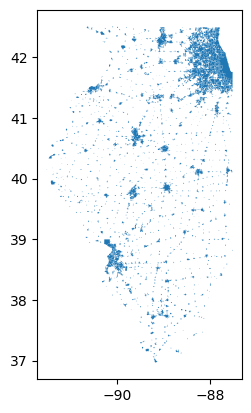

In [52]:
# Define info for big data download (Illinois)
census_data_url=("https://www2.census.gov/geo/tiger/TIGER2024/PLACE/tl_2024_17_place.zip"
)

census_data_dir = os.path.join(data_dir, 'census_data')
os.makedirs(census_data_dir, exist_ok=True)
census_data_path = os.path.join(census_data_dir, '*.shp') # Spatial Join 

# Only download the census tracts once
if not os.path.exists(census_data_path):
    census_data_gdf = gpd.read_file(census_data_url)
    census_data_gdf.to_file(census_data_path)
    chi_census_gdf = census_data_gdf[census_data_gdf.NAME=='Chicago']
    chi_census_gdf.to_file(census_data_gdf, index=False)
    

# Load in census tract data
census_data_gdf = gpd.read_file(census_data_path)

# Check the data - site plot - Census tracts with satellite imagery in the background
census_data_gdf.plot()


In [53]:
# Print the column names
print(census_data_gdf.columns)

Index(['STATEFP', 'PLACEFP', 'PLACENS', 'GEOID', 'GEOIDFQ', 'NAME', 'NAMELSAD',
       'LSAD', 'CLASSFP', 'PCICBSA', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')


## STEP 3 - Access Asthma and Urban Greenspaces Data

### Access human health data

The U.S. Center for Disease Control (CDC) provides a number of health
variables through their [Places
Dataset](https://www.cdc.gov/places/index.html) that might be correlated
with urban greenspace. For this assignment, start with adult asthma. Try
to limit the data as much as possible for download. Selecting the state
and county is a one way to do this.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>You can access Places data with an API, but as with many APIs it is
easier to test out your search before building a URL. Navigate to the <a
href="https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D">Places
Census Tract Data Portal</a> and search for the data you want.</li>
<li>The data portal will make an API call for you, but there is a
simpler, easier to read and modify way to form an API call. Check out to
the <a href="https://dev.socrata.com/docs/endpoints">socrata
documentation</a> to see how. You can also find some limited examples
and a list of available parameters for this API on <a
href="https://dev.socrata.com/foundry/data.cdc.gov/cwsq-ngmh">CDC Places
SODA Consumer API Documentation</a>.</li>
<li>Once you have formed your query, you may notice that you have
exactly 1000 rows. The Places SODA API limits you to 1000 records in a
download. Either narrow your search or check out the
<code>&amp;$limit=</code> parameter to increase the number of rows
downloaded. You can find more information on the <a
href="https://dev.socrata.com/docs/paging">Paging page of the SODA API
documentation</a></li>
<li>You should also clean up this data by renaming the
<code>'data_value'</code> to something descriptive, and possibly
selecting a subset of columns.</li>
</ol></div></div>

In [55]:
# Set up a path for the asthma data
cdc_path = os.path.join(data_dir, 'asthma.csv')

# Download asthma data (only once)
if not os.path.exists(cdc_path):
    asthma_url = (
        "https://data.cdc.gov/resource/cwsq-ngmh.csv"
        "?year=2022"
        "&stateabbr=IL"
        "&countyname=Cook"
        "&measureid=CASTHMA"
        "&$limit=1500"
    )
    asthma_df = (
        pd.read_csv(asthma_url)
        .rename(columns={
            'data_value': 'asthma',
            'low_confidence_limit': 'asthma_ci_low',
            'high_confidence_limit': 'asthma_ci_high',
            'locationname': 'tract'})
        [[
            'year', 'tract', 
            'asthma', 'asthma_ci_low', 'asthma_ci_high', 'data_value_unit',
            'totalpopulation', 'totalpop18plus'
        ]]
    )
    asthma_df.to_csv(asthma_path, index=False)

# Load in asthma data
asthma_df = pd.read_csv(asthma_path)

# Preview asthma data
asthma_df

year        tract  asthma  asthma_ci_low  asthma_ci_high  \
0     2022  17031031900     8.6            7.7             9.7   
1     2022  17031062600     8.3            7.3             9.3   
2     2022  17031070101     8.9            7.9             9.9   
3     2022  17031151200     8.6            7.7             9.7   
4     2022  17031241100     9.0            8.0            10.0   
...    ...          ...     ...            ...             ...   
1323  2022  17031834900    13.5           12.1            15.0   
1324  2022  17031828601     9.8            8.8            11.0   
1325  2022  17031843700     8.4            7.5             9.5   
1326  2022  17031829700    10.8            9.6            12.1   
1327  2022  17031829100    10.2            9.1            11.5   

     data_value_unit  totalpopulation  totalpop18plus  
0                  %             2522            2143  
1                  %             2477            1760  
2                  %             4171            3912  
3                  %             3880            3116  
4                  %             3574            3044  
...              ...              ...             ...  
1323               %             1952            1451  
1324               %             4198            3227  
1325               %             2544            1891  
1326               %             3344            2524  
1327               %             3512            2462  

[1328 rows x 8 columns]

### Join health data with census tract boundaries

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Join the census tract <code>GeoDataFrame</code> with the asthma
prevalence <code>DataFrame</code> using the <code>.merge()</code>
method.</li>
<li>You will need to change the data type of one of the merge columns to
match, e.g. using <code>.astype('int64')</code></li>
<li>There are a few census tracts in Chicago that do not have data. You
should be able to confirm that they are not listed through the
interactive Places Data Portal. However, if you have large chunks of the
city missing, it may mean that you need to expand the record limit for
your download.</li>
</ol></div></div>

In [ ]:
# Determine Data types 
print(census_data_gdf.dtypes)
print(asthma_df.dtypes)


In [68]:
asthma_df.columns


Index(['year', 'tract', 'asthma', 'asthma_ci_low', 'asthma_ci_high',
       'data_value_unit', 'totalpopulation', 'totalpop18plus'],
      dtype='object')

In [77]:
# Change tract identifier datatype for merging
chicago_gdf.tract2010 = chicago_gdf.tract2010.astype('int64')

# Merge census data with geometry
merged_gdf = (
    chicago_gdf
    .merge(asthma_df, left_on='tract2010', right_on='tract', how='inner')
)

# Plot asthma data as chloropleth
(
    gv.tile_sources.EsriImagery
    * 
    gv.Polygons(
        merged_gdf.to_crs(ccrs.Mercator()),
        vdims=['asthma', 'tract2010'],
        crs=ccrs.Mercator()
    ).opts(color='asthma', colorbar=True, tools=['hover'])
).opts(width=600, height=600, xaxis=None, yaxis=None)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (asthma,tract2010)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a description and citation for the asthma prevalence data. Do
you notice anything about the spatial distribution of asthma in Chicago?
From your research on the city, what might be some potential causes of
any patterns you see?</p></div></div>

**ADD YOUR CDC PLACES DESCRIPTION AND CITATION HERE**

### Get Data URLs

NAIP data are freely available through the Microsoft Planetary Computer
SpatioTemporal Access Catalog (STAC).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Get started with STAC by accessing the planetary computer catalog
with the following code:</p>
<div class="sourceCode" id="cb1"><pre
class="sourceCode python"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>e84_catalog <span class="op">=</span> pystac_client.Client.<span class="bu">open</span>(</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>    <span class="st">&quot;https://planetarycomputer.microsoft.com/api/stac/v1&quot;</span></span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a>)</span></code></pre></div></div></div>

In [10]:
# Connect to the planetary computer catalog

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Using a loop, for each Census Tract:</p>
<ol type="1">
<li><p>Use the following sample code to search for data, replacing the
names with applicable values with descriptive names:</p>
<div class="sourceCode" id="cb1"><pre
class="sourceCode python"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a>search <span class="op">=</span> e84_catalog.search(</span>
<span id="cb1-2"><a href="#cb1-2" aria-hidden="true" tabindex="-1"></a>    collections<span class="op">=</span>[<span class="st">&quot;naip&quot;</span>],</span>
<span id="cb1-3"><a href="#cb1-3" aria-hidden="true" tabindex="-1"></a>    intersects<span class="op">=</span>shapely.to_geojson(tract_geometry),</span>
<span id="cb1-4"><a href="#cb1-4" aria-hidden="true" tabindex="-1"></a>    datetime<span class="op">=</span><span class="ss">f&quot;</span><span class="sc">{</span>year<span class="sc">}</span><span class="ss">&quot;</span></span>
<span id="cb1-5"><a href="#cb1-5" aria-hidden="true" tabindex="-1"></a>)</span></code></pre></div></li>
<li><p>Access the url using
<code>search.assets['image'].href</code></p></li>
</ol></li>
<li><p>Accumulate the urls in a <code>pd.DataFrame</code> or
<code>dict</code> for later</p></li>
<li><p>Occasionally you may find that the STAC service is momentarily
unavailable. You should include code that will retry the request up to 5
times when you get the
<code>pystac_client.exceptions.APIError</code>.</p></li>
</ol></div></div>

> **Warning**
>
> As always – DO NOT try to write this loop all at once! Stick with one
> step at a time, making sure to test your work. You also probably want
> to add a `break` into your loop to stop the loop after a single
> iteration. This will help prevent long waits during debugging.

In [12]:
# Convert geometry to lat/lon for STAC

# Define a path to save NDVI stats

# Check for existing data - do not access duplicate tracts

# Loop through each census tract

    # Check if statistics are already downloaded for this tract

        # Repeat up to 5 times in case of a momentary disruption   

            # Try accessing the STAC

                # Search for tiles 

                # Build dataframe with tracts and tile urls

            # Try again in case of an APIError

In [ ]:
# Prepare URL and file path for download
hls_url = (
    "https://github.com/cu-esiil-edu/esiil-learning-portal/releases"
    "/download/data-release/redlining-foundations-data.zip"
)
hls_dir = os.path.join(data_dir, 'hls')

if not glob(os.path.join(hls_dir, '*.tif')):
    # Download sample raster data
    hls_response = requests.get(hls_url)

    # Save the raster data (uncompressed)
    with zipfile.ZipFile(BytesIO(hls_response.content)) as hls_zip:
        hls_zip.extractall(hls_dir)

### Compute NDVI Statistics

Next, calculate some metrics to get at different aspects of the
distribution of greenspace in each census tract. These types of
statistics are called **fragmentation statistics**, and can be
implemented with the `scipy` package. Some examples of fragmentation
statistics are:

Percentage vegetation  
The percentage of pixels that exceed a vegetation threshold (.12 is
common with Landsat) Mean patch size

The average size of **patches**, or contiguous area exceeding the
vegetation threshold. Patches can be identified with the `label`
function from `scipy.ndimage` Edge density

The proportion of edge pixels among vegetated pixels. Edges can be
identified by **convolving** the image with a **kernel** designed to
detect pixels that are different from their surroundings.

> **What is convolution?**
>
> If you are familiar with differential equations, convolution is an
> approximation of the LaPlace transform.
>
> For the purposes of calculating edge density, convolution means that
> we are taking all the possible 3x3 chunks for our image, and
> multiplying it by the kernel:
>
> $$
> \text{Kernel} =
> \begin{bmatrix}
> 1 & 1 & 1 \\
> 1 & -8 & 1 \\
> 1 & 1 & 1
> \end{bmatrix}
> $$
>
> The result is a matrix the same size as the original, minus the
> outermost edge. If the center pixel is the same as the surroundings,
> its value in the final matrix will be
> $-8 + 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = 0$. If it is higher than the
> surroundings, the result will be negative, and if it is lower than the
> surroundings, the result will be positive. As such, the edge pixels of
> our patches will be negative.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Select a single row from the census tract <code>GeoDataFrame</code>
using e.g. <code>.loc[[0]]</code>, then select all the rows from your
URL <code>DataFrame</code> that match the census tract.</li>
<li>For each URL in crop, merge, clip, and compute NDVI for that census
tract</li>
<li>Set a threshold to get a binary mask of vegetation</li>
<li>Using the sample code to compute the fragmentation statistics. Feel
free to add any other statistics you think are relevant, but make sure
to include a fraction vegetation, mean patch size, and edge density. If
you are not sure what any line of code is doing, make a plot or print
something to find out! You can also ask ChatGPT or the class.</li>
</ol></div></div>

In [14]:
# Skip this step if data are already downloaded 

    # Get an example tract

    # Loop through all images for tract

        # Open vsi connection to data

        # Crop data to the bounding box of the census tract

        # Clip data to the boundary of the census tract

        # Compute NDVI

        # Accumulate result

    # Merge data

    # Mask vegetation

    # Calculate mean patch size
    labeled_patches, num_patches = label(veg_mask)
    patch_sizes = np.bincount(labeled_patches.ravel())[1:]
    mean_patch_size = patch_sizes.mean()

    # Calculate edge density
    kernel = np.array([
        [1, 1, 1], 
        [1, -8, 1], 
        [1, 1, 1]])
    edges = convolve(veg_mask, kernel, mode='constant')
    edge_density = np.sum(edges != 0) / veg_mask.size

### Repeat for all tracts

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>Using a loop, for each Census Tract:</p>
<ol type="1">
<li><p>Using a loop, for each data URL:</p>
<ol type="1">
<li>Use <code>rioxarray</code> to open up a connection to the STAC
asset, just like you would a file on your computer</li>
<li>Crop and then clip your data to the census tract boundary &gt; HINT:
check out the <code>.clip_box</code> parameter <code>auto_expand</code>
and the <code>clip</code> parameter <code>all_touched</code> to make
sure you don’t end up with an empty array</li>
<li>Compute NDVI for the tract</li>
</ol></li>
<li><p>Merge the NDVI rasters</p></li>
<li><p>Compute:</p>
<ol type="1">
<li>total number of pixels within the tract</li>
<li>fraction of pixels with an NDVI greater than .12 within the tract
(and any other statistics you would like to look at)</li>
</ol></li>
<li><p>Accumulate the statistics in a file for later</p></li>
</ol></li>
<li><p>Using a conditional statement, ensure that you do not run this
computation if you have already saved values. You do not want to run
this step many times, or have to restart from scratch! There are many
approaches to this, but we actually recommend implementing your caching
in the previous cell when you generate your dataframe of URLs, since
that step can take a few minutes as well. However, the important thing
to cache is the computation.</p></li>
</ol></div></div>

In [16]:
# Skip this step if data are already downloaded 

    # Loop through the census tracts with URLs

        # Open all images for tract

            # Open vsi connection to data
            
            # Clip data
                
            # Compute NDVI

            # Accumulate result

        # Merge data

        # Mask vegetation

        # Calculate statistics and save data to file

        # Calculate mean patch size

        # Calculate edge density
        
        # Add a row to the statistics file for this tract

# Re-load results from file

## STEP 3 - Explore your data with plots

### Chloropleth plots

Before running any statistical models on your data, you should check
that your download worked. You should see differences in both median
income and mean NDVI across the City.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Create a plot that contains:</p>
<ul>
<li>2 side-by-side Chloropleth plots</li>
<li>Asthma prevelence on one and mean NDVI on the other</li>
<li>Make sure to include a title and labeled color bars</li>
</ul></div></div>

In [18]:
# Merge census data with geometry

# Plot chloropleths with vegetation statistics

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-response"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div></div><div class="callout-body-container callout-body"><p>Do you see any similarities in your plots? Do you think there is a
relationship between adult asthma and any of your vegetation statistics
in Chicago? Relate your visualization to the research you have done (the
context of your analysis) if applicable.</p></div></div>

**ADD YOUR PLOT DESCRIPTION HERE**

## STEP 4: Explore a linear ordinary least-squares regression

### Model description

One way to find if there is a statistically significant relationship
between asthma prevalence and greenspace metrics is to run a linear
ordinary least squares (OLS) regression and measure how well it is able
to predict asthma given your chosen fragmentation statistics.

Before fitting an OLS regression, you should check that your data are
appropriate for the model.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a model description for the linear ordinary least-squares
regression that touches on:</p>
<ol type="1">
<li>Assumptions made about the data</li>
<li>What is the objective of this model? What metrics could you use to
evaluate the fit?</li>
<li>Advantages and potential problems with choosing this model.</li>
</ol></div></div>

**ADD YOUR CDC PLACES DESCRIPTION AND CITATION HERE**

### Data preparation

When fitting statistical models, you should make sure that your data
meet the model assumptions through a process of selection and/or
transformation.

You can select data by:

-   Eliminating observations (rows) or variables (columns) that are
    missing data
-   Selecting a model that matches the way in which variables are
    related to each other (for example, linear models are not good at
    modeling circles)
-   Selecting variables that explain the largest amount of variability
    in the dependent variable.

You can transform data bt:

-   Transforming a variable so that it follows a normal distribution.
    The `log` transform is the most common to eliminate excessive skew
    (e.g. make the data symmetrical), but you should select a transform
    most suited to your data.
-   Normalizing or standardizing variables to, for example, eliminate
    negative numbers or effects caused by variables being in a different
    range.
-   Performing a principle component analysis (PCA) to eliminate
    multicollinearity among the predictor variables

> **Tip**
>
> Keep in mind that data transforms like a log transform or a PCA must
> be reversed after modeling for the results to be meaningful.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the <code>hvplot.scatter_matrix()</code> function to create an
exploratory plot of your data.</li>
<li>Make any necessary adjustments to your data to make sure that they
meet the assumptions of a linear OLS regression.</li>
<li>Check if there are <code>NaN</code> values, and if so drop those
rows and/or columns. You can use the <code>.dropna()</code> method to
drop rows with <code>NaN</code> values.</li>
<li>Explain any data transformations or selections you made and why</li>
</ol></div></div>

In [20]:
# Variable selection and transformation

**EXPLAIN YOUR SELECTION AND TRANSFORMATION PROCESS HERE**

### Fit and Predict

If you have worked with statistical models before, you may notice that
the `scikitlearn` library has a slightly different approach than many
software packages. For example, `scikitlearn` emphasizes generic model
performance measures like cross-validation and importance over
coefficient p-values and correlation. The scikitlearn approach is meant
to generalize more smoothly to machine learning (ML) models where the
statistical significance is harder to derive mathematically.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Use the scikitlearn documentation or ChatGPT as a starting point,
split your data into training and testing datasets.</li>
<li>Fit a linear regression to your training data.</li>
<li>Use your fitted model to predict the testing values.</li>
<li>Plot the predicted values against the measured values. You can use
the following plotting code as a starting point.</li>
</ol></div></div>

In [22]:
# Select predictor and outcome variables

# Split into training and testing datasets

# Fit a linear regression

# Predict asthma values for the test dataset

# Plot measured vs. predicted asthma prevalence with a 1-to-1 line
(
    test_df
    .hvplot.scatter(x='measured', y='predicted')
    .opts(aspect='equal', 
          xlim=(0, y_max), ylim=(0, y_max), 
          width=600, height=600)
) * hv.Slope(slope=1, y_intercept=0).opts(color='black')

### Spatial bias

We always need to think about bias, or systematic error, in model
results. Every model is going to have some error, but we’d like to see
that error evenly distributed. When the error is systematic, it can be
an indication that we are missing something important in the model.

In geographic data, it is common for location to be a factor that
doesn’t get incorporated into models. After all – we generally expect
places that are right next to each other to be more similar than places
that are far away (this phenomenon is known as *spatial
autocorrelation*). However, models like this linear regression don’t
take location into account at all.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Compute the model error (predicted - measured) for all census
tracts</li>
<li>Plot the error as a chloropleth map with a diverging color
scheme</li>
<li>Looking at both of your error plots, what do you notice? What are
some possible explanations for any bias you see in your model?</li>
</ol></div></div>

In [24]:
# Compute model error for all census tracts

# Plot error geographically as a chloropleth

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What do you notice about your model from looking at the error plots?
What additional data, transformations, or model type might help improve
your results?</p></div></div>

**DESCRIBE AND INTERPRET YOUR IMAGE HERE**